<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit8/Tavi_Tragus_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a graph that is a tree (amr definition). It is connected and has no cycles. There is a root node , and branch nodes and leaf nodes. In the decisions trees we have cutoff points on the root and branch nodes to decided how we break up data. Then the leaf nodes have y values that the data in that section is split into. This basically gives us a list of vertical and horizontal lines we connect to make our model.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is how many layers it has. More layers means more capability to section data off, making it fit better. If a tree is too deep it will overfit. If a tree is not deep enough it will underfit.

**Task4:**

How are BART models similar and different from a decision tree?

A BART model uses a combination of decision trees. It is similar to a random forest, but selects decision trees to try to keep them shallow and independent from eachother.

**Task5**:

Why would we use a BART model instead of a decision tree?

A BART model can have more nuance without overfitting.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [1]:
!pip install preliz

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import seaborn as sns

In [3]:
!pip install pymc_bart

In [4]:
import pymc_bart as pmb

In [5]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [6]:
features = ["flipper_length", "bill_length", "bill_depth"]

X = penguins[features]#.to_numpy().reshape(-1, 1)
Y = penguins["body_mass"].to_numpy()
flip = penguins["flipper_length"]

In [7]:
with pm.Model() as model_peng:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_peng = pm.sample()

Output()

Output()

<Axes: xlabel='y'>

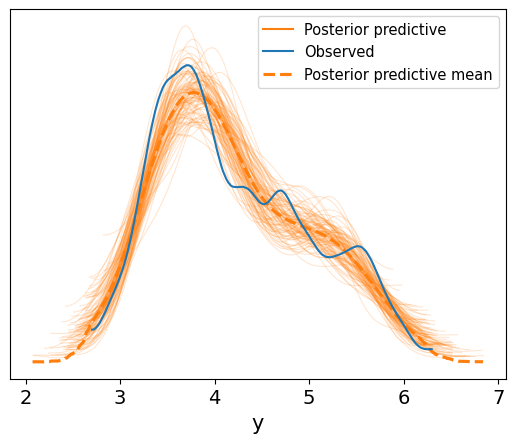

In [8]:
pm.sample_posterior_predictive(idata_peng,model_peng, extend_inferencedata=True)
az.plot_ppc(idata_peng, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [9]:
posterior_mean = idata_peng.posterior["μ"]

μ_hdi = az.hdi(ary=idata_peng, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_peng, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


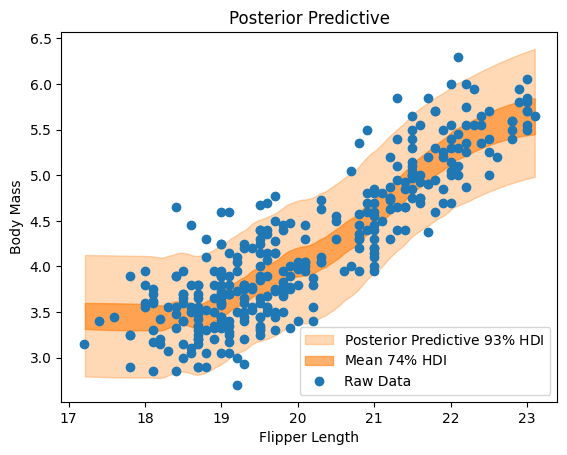

In [10]:
idx = np.argsort(flip)
fig, ax = plt.subplots()

az.plot_hdi(
    x=flip,
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=flip,
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Flipper Length",
    ylabel="Body Mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think the middle is good, but the ends are both becoming flat, and I don't know how accurate that is. Overall it makes sense that larger flippers correlate to a higher body mass, because you need more flipper to move more mass. I think the model fits the data well though, because the flatening out does seem to be present.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

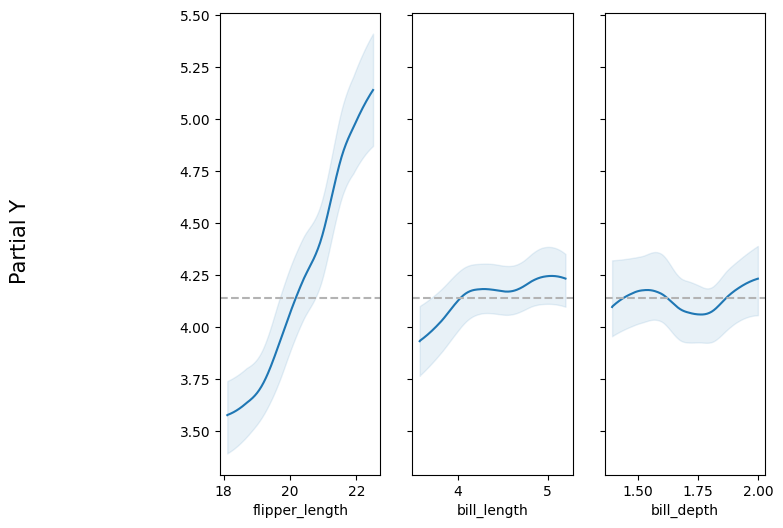

In [11]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

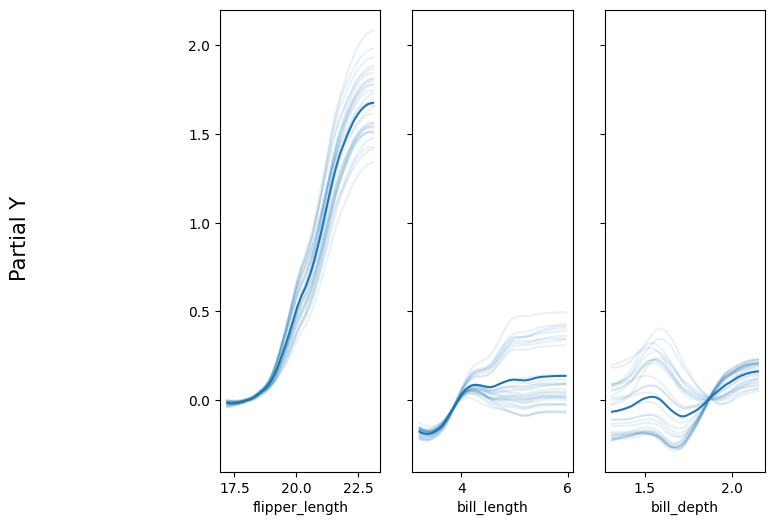

In [12]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [13]:
vi_peng = pmb.compute_variable_importance(idata_peng, μ_, X)

<Axes: ylabel='R²'>

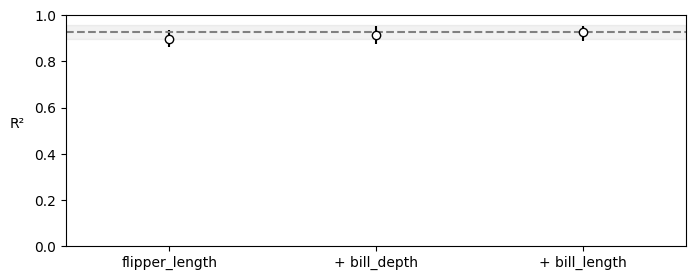

In [14]:
pmb.plot_variable_importance(vi_peng)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

I think flipper length is the most important predictor for body mass. The pdp and ice plots both indicate that flipper length has a big impact on body weight. The ice plot is tightly grouped for all flipper length values, whereas it is spread out for higher bill length values and lower bill depth values. The variable importance chart shows that all variables are within acceptable R^2 values, but that bill length is the best. I still think due to the clearer trend in the ice plot and the physical necessity for larger flippers to move a larger penguin through the water, that flipper length is the most important predictor.  